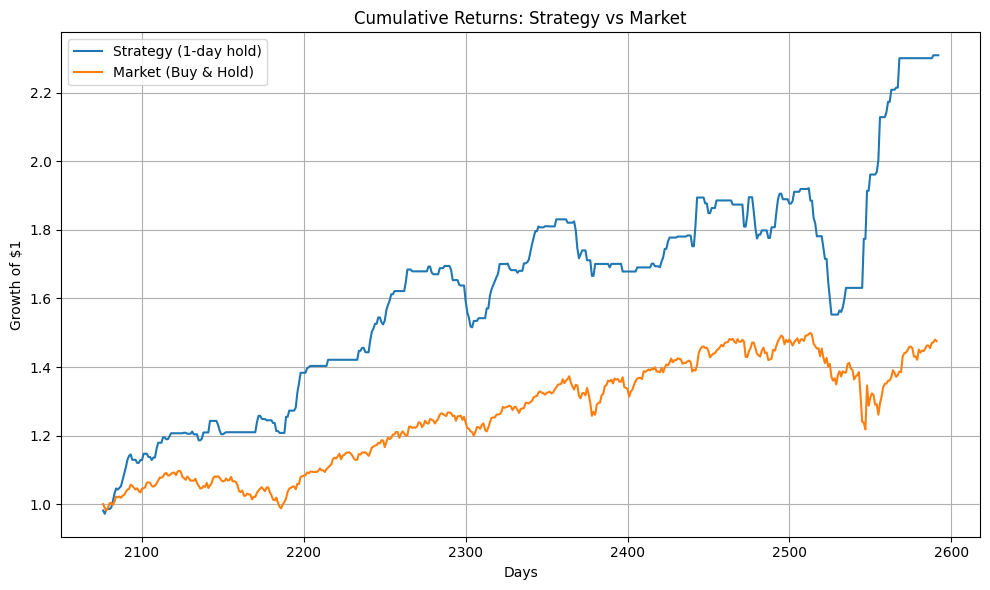

Total trades taken: 201


In [66]:
# backtest.ipynb

# 📦 Load model and test data
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt

# Load trained model
DATA_DIR = "../data"
model = joblib.load(os.path.join("../models", "random_forest_model.joblib"))

# Load one of the feature files or the merged test set
df = pd.read_parquet(os.path.join(DATA_DIR, "features_SPY.parquet"))

# Detect actual Date column and sort
date_col = next((col for col in df.columns if col.lower().startswith("date")), None)
if date_col is None:
    raise KeyError(f"Could not find date column in: {df.columns.tolist()}")
df = df.sort_values(date_col).reset_index(drop=True)

# Feature columns used in the original model
FEATURE_COLUMNS = [
    "ret_1", "daily_return", "stoch_d", "rolling_vol_5", "bb_width",
    "momentum_10", "rsi_14", "stoch_k", "atr_14", "macd_signal", "macd"
]

# Split data
split_idx = int(len(df) * 0.8)
X_test = df[FEATURE_COLUMNS].iloc[split_idx:].copy()
y_test = df["target"].iloc[split_idx:].copy()

# 📊 Predict using model
probs = model.predict_proba(X_test)[:, 1]
preds = model.predict(X_test)

# 📈 Build working DataFrame for backtest
df_bt = X_test.copy()
df_bt['pred'] = preds
df_bt['proba'] = probs
df_bt['actual'] = y_test.reset_index(drop=True)
df_bt['daily_return'] = df.loc[df_bt.index, 'daily_return'].values

# 🧠 Strategy: Buy if pred=1 and proba > 0.55
signal = (df_bt['pred'] == 1) & (df_bt['proba'] > 0.55)

# Drop last row to avoid shift NaN
df_bt = df_bt[:-3]
signal = signal[:-3]  # Align signal length

# Compute strategy returns
# Shifted returns for 3-day hold
r1 = df_bt['daily_return'].shift(-1)
r2 = df_bt['daily_return'].shift(-2)
r3 = df_bt['daily_return'].shift(-3)

# Sum them only when signal fires
df_bt['strategy_return'] = np.where(signal, r1 + r2 + r3, 0)

# 📊 Cumulative returns
df_bt['cumulative_strategy'] = (1 + df_bt['strategy_return']).cumprod()
df_bt['cumulative_market'] = (1 + df_bt['daily_return'].shift(-1)).cumprod()

# 📉 Plot performance
plt.figure(figsize=(10, 6))
plt.plot(df_bt['cumulative_strategy'], label='Strategy (1-day hold)')
plt.plot(df_bt['cumulative_market'], label='Market (Buy & Hold)')
plt.legend()
plt.title("Cumulative Returns: Strategy vs Market")
plt.xlabel("Days")
plt.ylabel("Growth of $1")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: show number of signals
total_signals = signal.sum()
print(f"Total trades taken: {total_signals}")


In [68]:
# --- Performance Metrics ---

import numpy as np

# Strategy values
returns = df_bt['strategy_return']
cumulative_returns = df_bt['cumulative_strategy']

# 1. CAGR (assuming 252 trading days/year)
n_years = len(df_bt) / 252
ending_value = cumulative_returns.iloc[-1]
cagr = (ending_value) ** (1 / n_years) - 1

# 2. Sharpe Ratio (assuming risk-free rate = 0)
sharpe = (returns.mean() / returns.std()) * np.sqrt(252)

# 3. Max Drawdown
rolling_max = cumulative_returns.cummax()
drawdown = cumulative_returns / rolling_max - 1
max_drawdown = drawdown.min()

# 4. Win Rate
win_rate = (returns > 0).sum() / (returns != 0).sum()

# 5. Avg Return per Trade
avg_return_per_trade = returns[returns != 0].mean()

# Print metrics
print(f"CAGR: {cagr:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Win Rate: {win_rate:.2%}")
print(f"Avg Return per Trade: {avg_return_per_trade:.4f}")


CAGR: 50.36%
Sharpe Ratio: 2.48
Max Drawdown: -19.17%
Win Rate: 63.18%
Avg Return per Trade: 0.0043
